### Scraping data from Skytrax
[https://www.airlinequality.com/airline-reviews/british-airways]

In [76]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []
for i in range(1, pages + 1):

    print(f"Scraping page {i}")
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"
    response = requests.get(url)
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | First time flying British Ai...
1,Not Verified | I flew London to Cairo and ret...
2,Not Verified | Absolutely the worst experienc...
3,Not Verified | Flew back from Malta after sc...
4,Not Verified | Cabin luggage had to go to carg...


In [4]:
df.to_csv("data/BA_reviews2.csv")

In [77]:
data = pd.read_csv("data/BA_reviews2.csv")

In [78]:
MyData = []
lines = data["reviews"].values.tolist()
SW = ['sister', 'los_angeles', 'whats','flight', 'fly', 'would', 'bring', 'passenger', 'ive','the','glasgow','apply', 'latest', 'lady', 'wont','example','mostly', 'dubrovnik', 'youre','sometimes', 'day', 'london','british', 'hour', 'airline', 'johannesburg', 'previous', 'consider','pre', 'overall', 'traveller', 'definitely', 'truly', 'get', 'one', 'make', 'compare', 'tell', 'amount', 'attend', 'assign', 'along', 'husband', 'theyre']
print('len SW ==', len(SW))
for rev in lines:
    rev = rev.lower()
    rev = re.sub(r'✅ trip verified |', "", rev)
    rev = re.sub(r'not verified |', "", rev)
    rev = re.sub(r"\'ll", "will", rev)
    rev = re.sub(r"\'ve", "have", rev)
    rev = re.sub(r"won't", "will not", rev)
    rev = re.sub(r"don't", "do not", rev)
    rev = re.sub(r"didn't", "did not", rev)
    rev = re.sub(r"can't", "can not", rev)
    rev = re.sub(r"couldn't", "could not", rev)
    rev = re.sub(r"haven't", "have not", rev)
    rev = re.sub(r"hasn't", "has not", rev)
    rev = re.sub(r"doesn't", "does not", rev)
    rev = re.sub(r'[^\w\s]', '', rev)
    rev = re.sub(r'[\d]', '', rev)
    rev = re.sub(r'\xa0', '', rev)
    #tokenization
    tokens = word_tokenize(rev) 
    
    #stop_words 
    stop_words = set(stopwords.words('english'))
    stop_words.discard("not")
    for w in range(len(SW)):
        stop_words.add(SW[w])
    
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(w, pos = "v") for w in tokens if not(w in stop_words)]
    words = [lemmatizer.lemmatize(w, pos = "n") for w in words if not(w in stop_words)]
    words = [w for w in words if len(w)>2]
    MyData.append(words)

len SW == 44


In [79]:
# Bigrams and Trigrams
bigram = gensim.models.Phrases(MyData, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[MyData], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
data_bigrams = [bigram_mod[doc] for doc in MyData]
data_bi_trigrams= [trigram_mod[bigram_mod[doc]] for doc in MyData]

In [80]:
id_word = corpora.Dictionary(data_bi_trigrams)
corpus = []
corpus = [id_word.doc2bow(text) for text in data_bi_trigrams]

In [81]:
#TF_IDF
"""
from gensim.models import TfidfModel
id_word  = corpora.Dictionary(data_bi_trigrams)
texts = data_bi_trigrams
corpus = [id_word.doc2bow(text) for text in texts]

tfidf = TfidfModel(corpus, id2word=id_word)
low_value = 0.041
words_missing_tfidf = []

for i in range(len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in bow]
    bow_ids = [id for id, value in tfidf[bow]]
    low_value_words = [id for id, value in tfidf[bow] if value<low_value]
    drops = low_value_words + words_missing_tfidf
    for item in drops:
        words.append(id_word[item])
    words_missing_tdfidf = [id for id in bow_ids if id not in tfidf_ids]
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_tdfidf]
    corpus[i] = new_bow
"""

'\nfrom gensim.models import TfidfModel\nid_word  = corpora.Dictionary(data_bi_trigrams)\ntexts = data_bi_trigrams\ncorpus = [id_word.doc2bow(text) for text in texts]\n\ntfidf = TfidfModel(corpus, id2word=id_word)\nlow_value = 0.041\nwords_missing_tfidf = []\n\nfor i in range(len(corpus)):\n    bow = corpus[i]\n    low_value_words = []\n    tfidf_ids = [id for id, value in bow]\n    bow_ids = [id for id, value in tfidf[bow]]\n    low_value_words = [id for id, value in tfidf[bow] if value<low_value]\n    drops = low_value_words + words_missing_tfidf\n    for item in drops:\n        words.append(id_word[item])\n    words_missing_tdfidf = [id for id in bow_ids if id not in tfidf_ids]\n    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_tdfidf]\n    corpus[i] = new_bow\n'

In [82]:
num_topics = 8
LDA_Model = gensim.models.LdaModel(corpus = corpus,
                                   id2word = id_word,
                                   num_topics = num_topics,
                                   random_state = 36,
                                   update_every = 1,
                                   chunksize = 100,
                                   passes = 10,
                                   iterations=100,
                                   alpha = 'auto',
                                   per_word_topics = True)


In [102]:
coherence_model_lda = CoherenceModel(model=LDA_Model, texts = MyData, dictionary=id_word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence score =', coherence_lda)

C:\Users\LENOVO\anaconda3\envs\NLP_env\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
C:\Users\LENOVO\anaconda3\envs\NLP_env\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


Coherence score = nan


In [84]:
from pprint import pprint
pprint(LDA_Model.print_topics())

[(0,
  '0.033*"good" + 0.020*"lounge" + 0.018*"serve" + 0.016*"breakfast" + '
  '0.014*"dinner" + 0.012*"singapore" + 0.011*"drink" + 0.011*"hot" + '
  '0.010*"arrival" + 0.010*"quality"'),
 (1,
  '0.035*"not" + 0.024*"book" + 0.023*"customer" + 0.019*"call" + '
  '0.015*"airway" + 0.013*"try" + 0.012*"ticket" + 0.012*"say" + 0.011*"hour" '
  '+ 0.010*"service"'),
 (2,
  '0.023*"decent" + 0.020*"big" + 0.018*"something" + 0.011*"replace" + '
  '0.010*"filthy" + 0.009*"bangalore" + 0.009*"wear" + 0.008*"boston" + '
  '0.008*"headrest" + 0.007*"delhi"'),
 (3,
  '0.035*"cancel" + 0.033*"voucher" + 0.032*"refund" + 0.015*"book" + '
  '0.015*"new_york" + 0.013*"call" + 0.012*"message" + 0.012*"line" + '
  '0.010*"fee" + 0.010*"hotel"'),
 (4,
  '0.025*"class" + 0.023*"business" + 0.019*"first" + 0.013*"service" + '
  '0.013*"experience" + 0.011*"best" + 0.011*"excellent" + 0.010*"thank" + '
  '0.010*"airway" + 0.008*"product"'),
 (5,
  '0.055*"seat" + 0.024*"food" + 0.021*"cabin" + 0.020*"cr

In [85]:
def mainTopics(ldamodel = 'None', corpus = corpus, data = data):
    main_topics_df = pd.DataFrame()
    for i, row_list in enumerate(ldamodel[corpus]):
        
        row = row_list[0]
        row = sorted(row, key =lambda x: x[1], reverse = True)

        for j, (topic_num, contribution_t_doc) in enumerate(row):
            if j == 0:
                keywords = ""
                y = ldamodel.show_topic(topic_num)
                keywords = ",".join([str(w) for w, p in y])
                new_data = pd.Series([int(topic_num), round(contribution_t_doc, 3), keywords])
                new_df = pd.DataFrame([new_data])
                main_topics_df = pd.concat([main_topics_df, new_df], ignore_index=True)
            else:
                break
    main_topics_df.columns = ["Dominant_topic", "contribution", "topic_keywords"]
    return(main_topics_df)
    
main_topics_df = mainTopics(ldamodel = LDA_Model, corpus = corpus, data = MyData)
topic_df = main_topics_df.reset_index()
topic_df.columns = ["Doc_nbr", "Dominant_topic", "contribution", "topic_keywords"]


In [86]:
topic_df.head(5)

,Doc_nbr,Dominant_topic,contribution,topic_keywords
0,0,5,0.485,"seat,food,cabin,crew,not,good,service,economy,..."
1,1,5,0.727,"seat,food,cabin,crew,not,good,service,economy,..."
2,2,1,0.509,"not,book,customer,call,airway,try,ticket,say,h..."
3,3,5,0.617,"seat,food,cabin,crew,not,good,service,economy,..."
4,4,7,0.320,"not,staff,take,time,delay,board,service,check,..."


######## Visualization #########

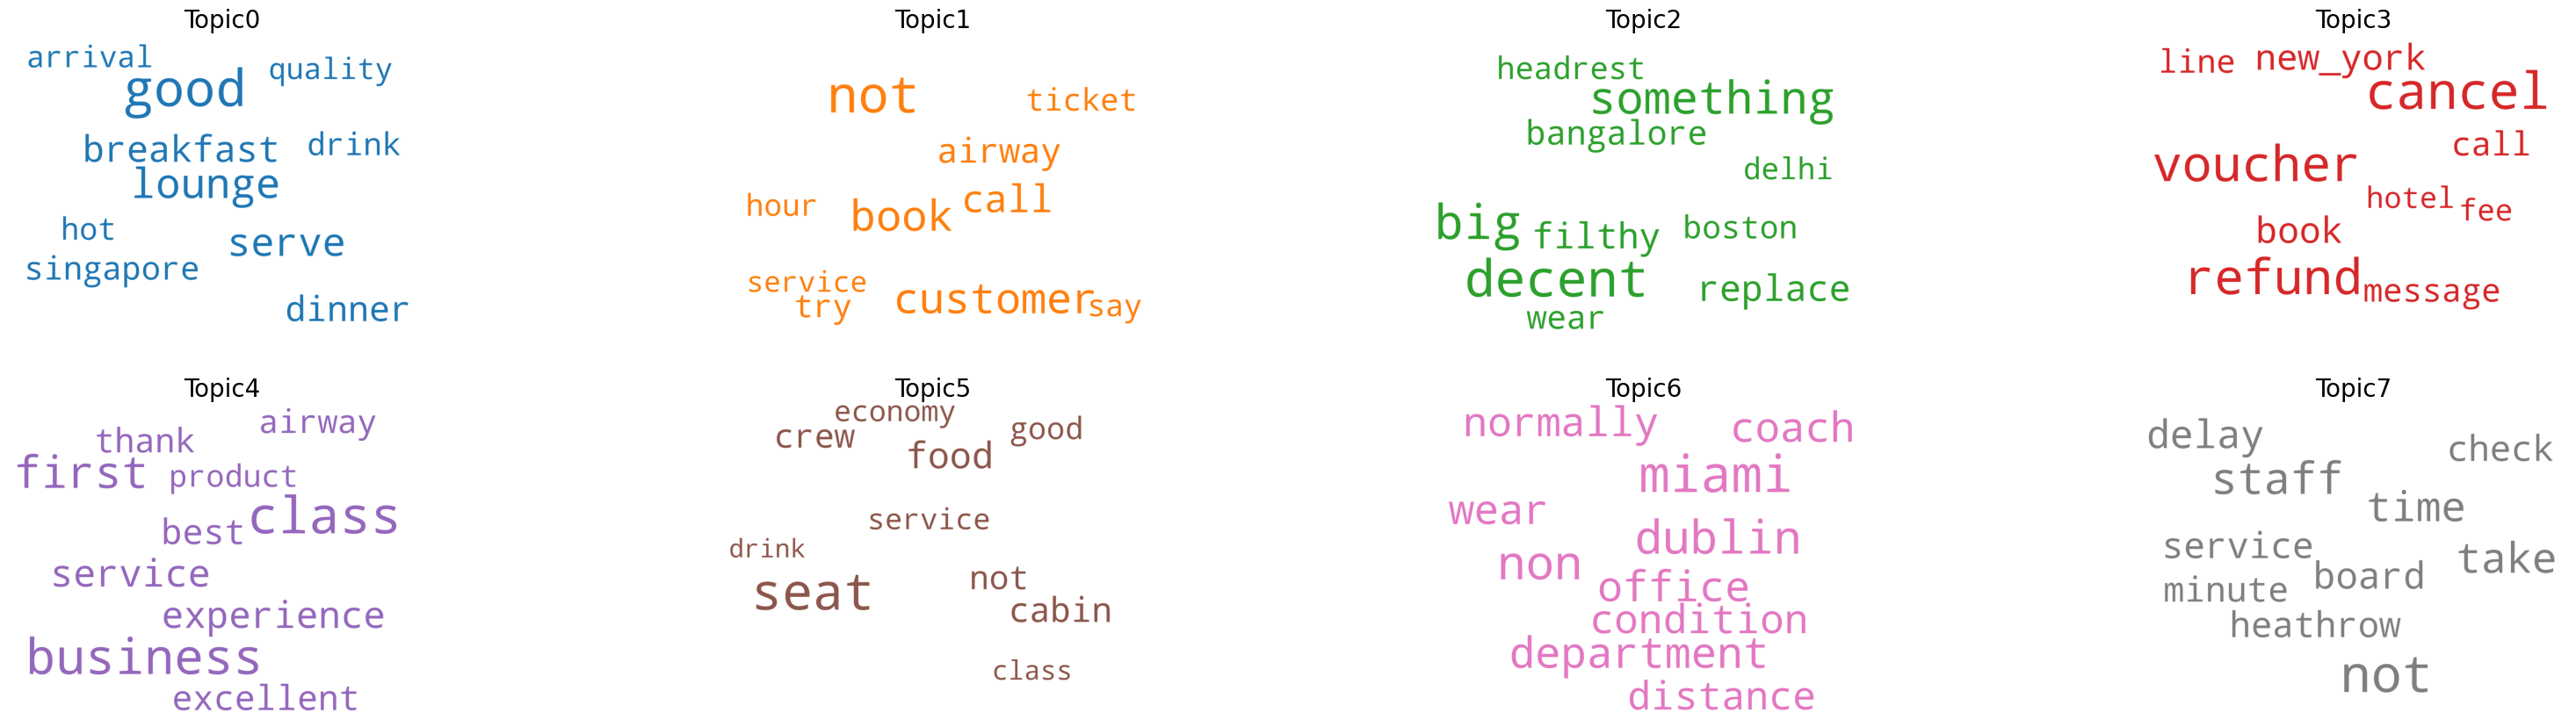

In [87]:
#WordCloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

colors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords = stopwords,
                 background_color = 'white',
                 width = 2500,
                 height = 1800,
                 max_words = 20,
                 colormap = 'tab10',
                 color_func=lambda *args, **kwargs: colors[i],
                 prefer_horizontal =1.0)

topics = LDA_Model.show_topics(num_topics=num_topics, formatted = False)

fig, axes = plt.subplots(2, 4, figsize=(40, 10), sharex=True, sharey= True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size = 300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic' + str(i), fontsize = 20)
    plt.gca().axis('off')

plt.axis('off')
plt.show()

keyerror


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_6992\487284726.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, "word"], rotation = 30, horizontalalignment = "right", fontsize = 20 )


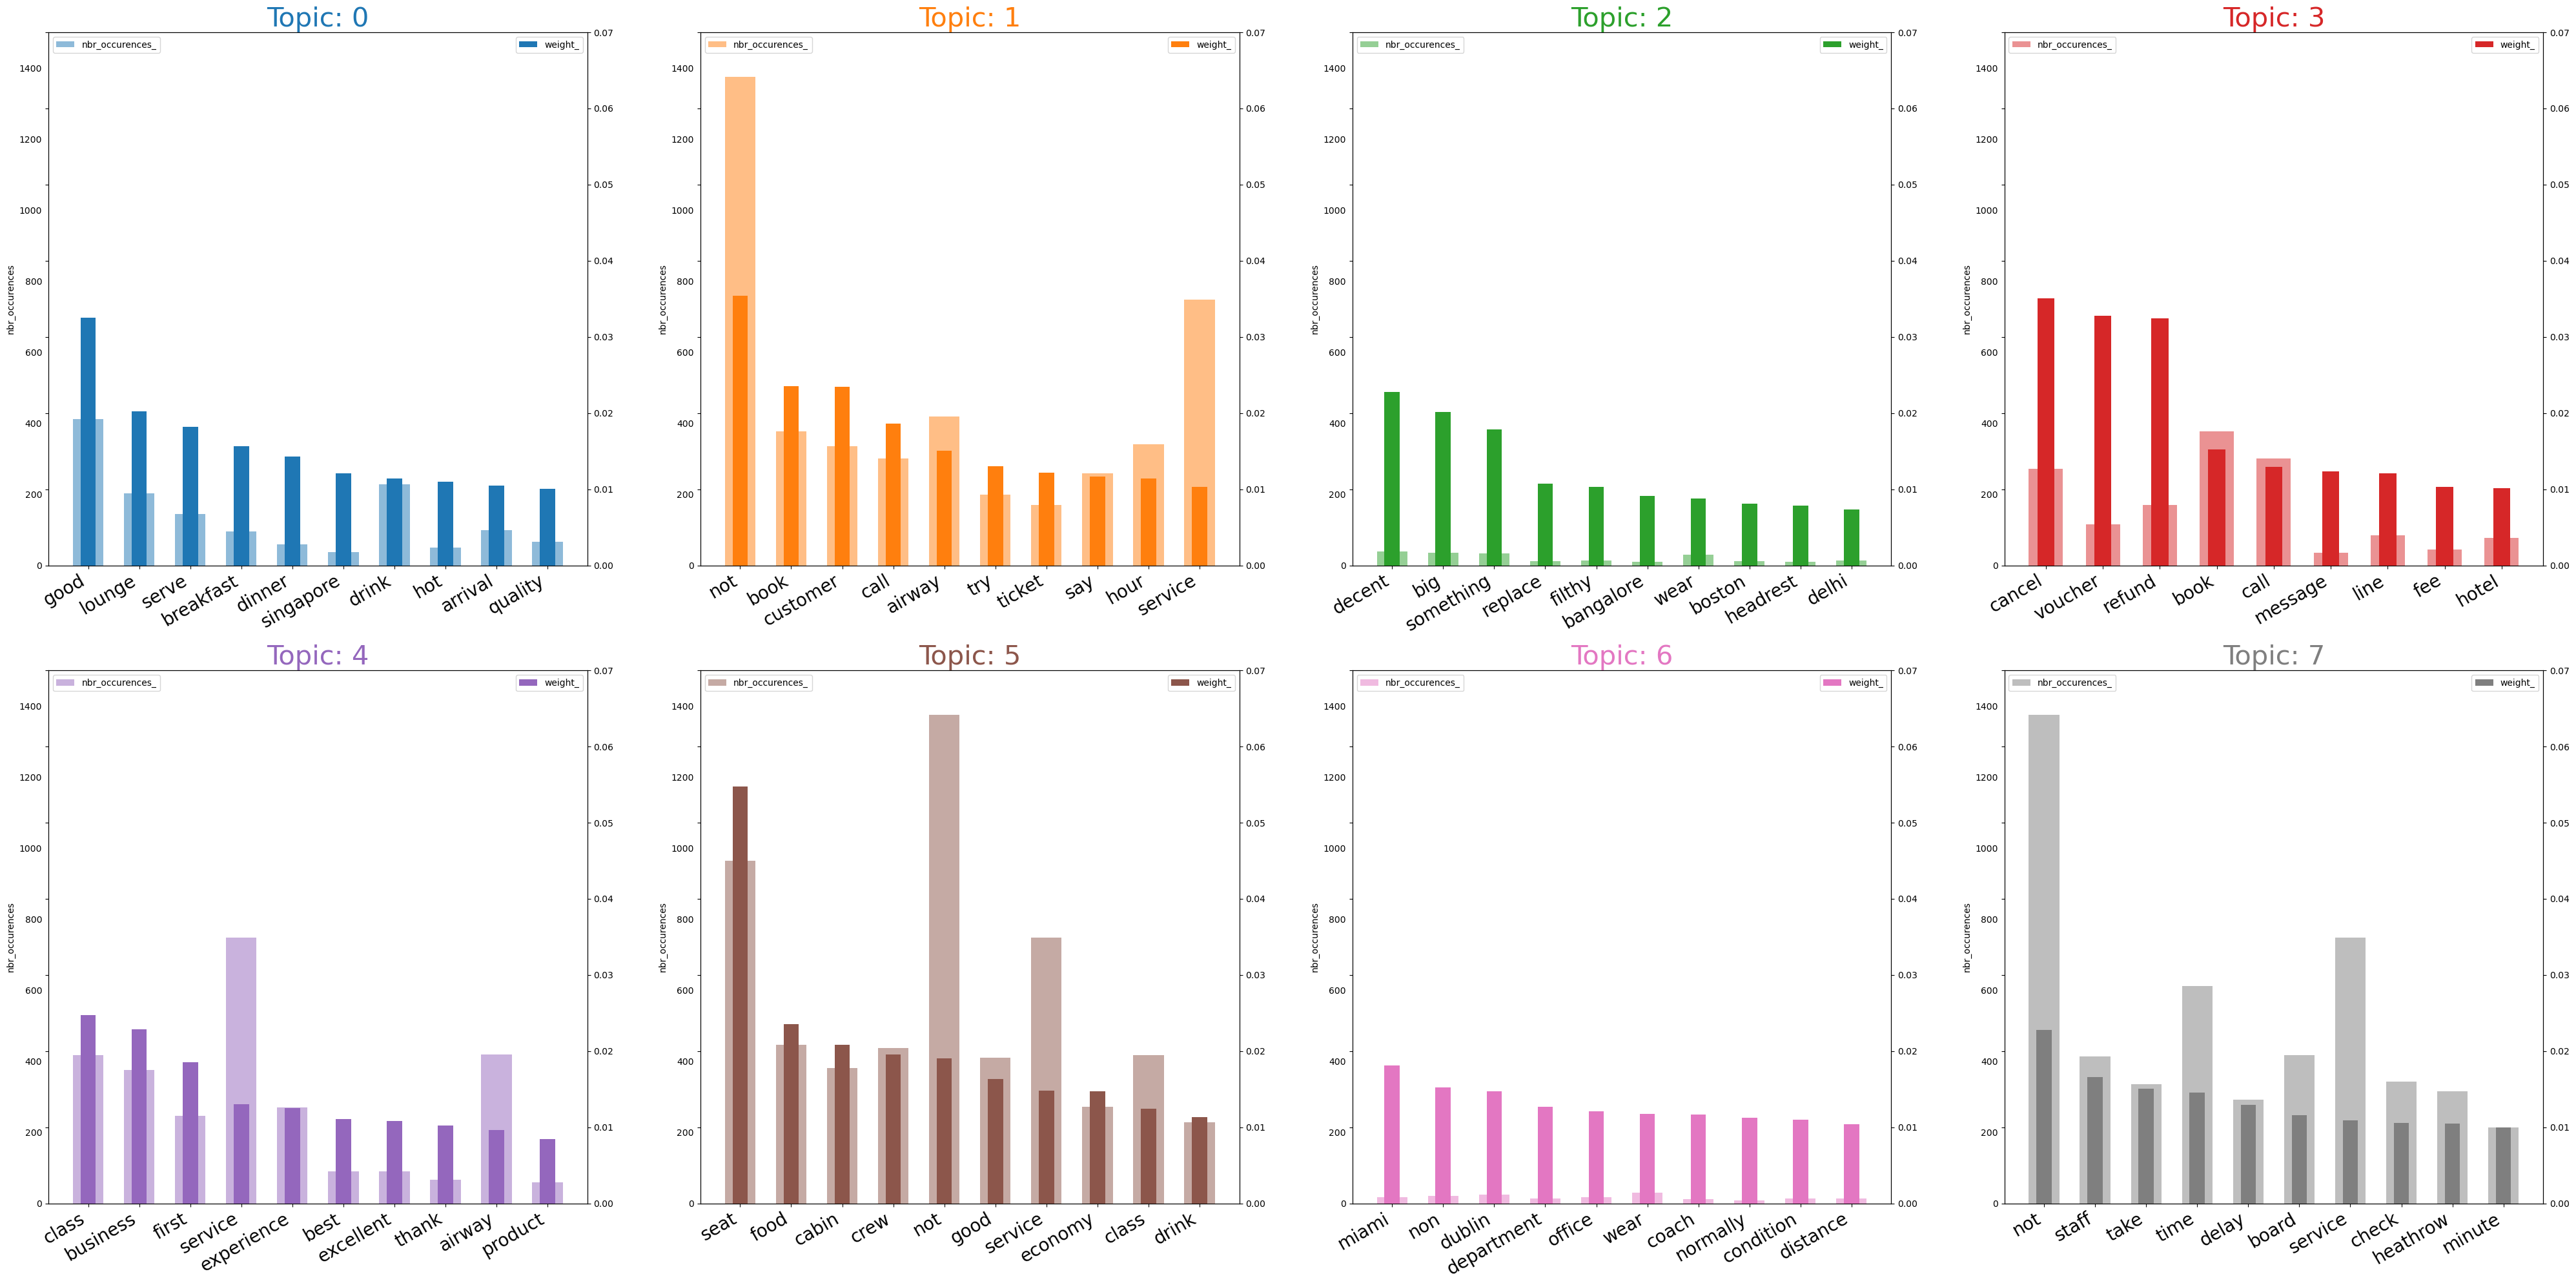

In [137]:
# Counts of Topic Keywords
def counter(data):
    counter = {}
    for i in range(len(data)):
        counter[data[i]] = 1 + counter.get(data[i], 0)
    return counter

dt =[w for w_list in MyData for w in w_list]
counter = counter(dt)
out =[]
topics = LDA_Model.show_topics(num_topics = num_topics, formatted = False)
for i, topic in topics:
    for word, weight in topic:
        try:
            out.append([word, i, weight, counter[word]])
        except KeyError :
            print('keyerror')
        
df = pd.DataFrame(out, columns = ['word', 'topic_id', 'weight', 'nbr_occurence'])

#plot nbr_occurences & weight of keywords

fig, axes = plt.subplots(2, 4, figsize = (40, 20))
for i, ax in enumerate(axes.flatten()):
    ax.bar(x = "word", height = "nbr_occurence", data = df.loc[df.topic_id == i, :], color = colors[i],  alpha = 0.5, width = 0.6, label = "nbr_occurences_")
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height = "weight", data = df.loc[df.topic_id == i, :], color = colors[i], width = 0.3, label= "weight_")
    ax.set_ylabel('nbr_occurences')
    ax_twin.set_ylim(0, 0.07); ax.set_ylim(0, 1500)
    ax.set_title("Topic: " + str(i), fontsize = 30, color = colors[i])
    ax.tick_params(axis='y', left=False)
    ax_twin.tick_params(axis='y', left=True)
    ax.set_xticklabels(df.loc[df.topic_id==i, "word"], rotation = 30, horizontalalignment = "right", fontsize = 20 )
    ax.legend(loc = "upper left")
    ax_twin.legend(loc = "upper right")

fig.tight_layout(w_pad=5)    
#fig.suptitle("Occurrences & weight of topic keywords", fontsize=22)
plt.show()

In [89]:
dominant_topic_in_doc = topic_df.groupby('Dominant_topic').size()
dominant_topic_in_doc = dominant_topic_in_doc.to_frame(name='count').reset_index()
dominant_topic_in_doc

,Dominant_topic,count
0,0,10
1,1,184
2,3,5
3,4,40
4,5,381
5,6,1
6,7,379


In [90]:
import numpy as np

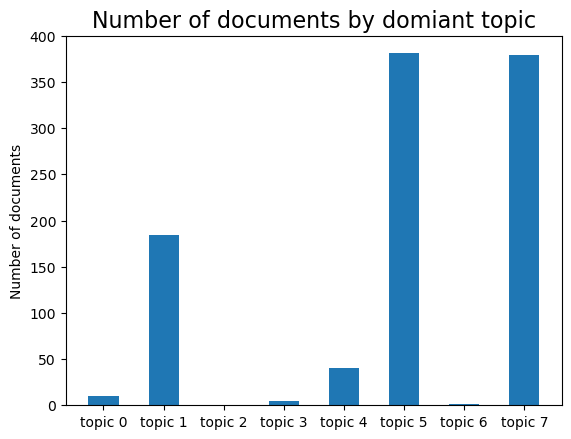

In [118]:
fig, ax = plt.subplots()
ax.bar(x=dominant_topic_in_doc["Dominant_topic"], height=dominant_topic_in_doc["count"], width=0.5)
ax.set_xticks(range(0, dominant_topic_in_doc.shape[0]+1))
ax.set_title('Number of documents by domiant topic', fontsize=16)
ax.set_ylabel('Number of documents')
ax.set_xticklabels( ["topic " + str(i) if i in dominant_topic_in_doc.Dominant_topic else "topic 7" for i in range(8)])
ax.set_ylim = (0,400)
#ax.set_xticklabels( ["topic " + str(i) for i in dominant_topic_in_doc.Dominant_topic])    
plt.show()

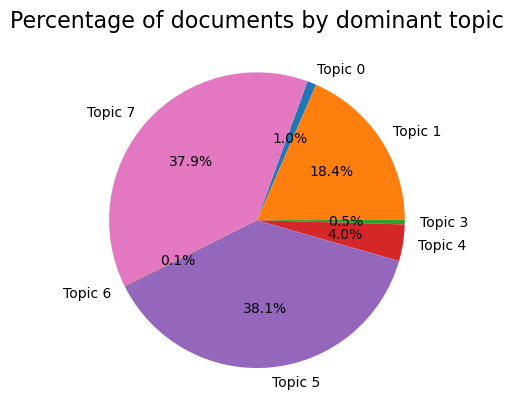

In [131]:
dtid = {"Dominant_topic": [0, 1, 2, 3, 4, 5, 6, 7], "count": dominant_topic_in_doc["count"]}
fig, ax = plt.subplots()
ax.pie(dtid["count"], labels=["Topic 0", "Topic 1", "Topic 3", "Topic 4", "Topic 5", "Topic 6", "Topic 7"], autopct='%1.1f%%', startangle=70, counterclock=False)
ax.set_title('Percentage of documents by dominant topic', fontsize=16)
plt.show()

In [92]:
""""
import os
import pickle
import json

pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('C:/Users/LENOVO/Desktop/Projects/British Airlines/ldavisu')
if 1 == 1:
    LDAvis = pyLDAvis.gensim_models.prepare(LDA_Model, corpus, id_word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis, f)

with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis = pickle.load(f)

pyLDAvis.save_html(LDAvis, 'C:/Users/LENOVO/Desktop/Projects/British Airlines/ldavisu'+'.html')"""

'"\nimport os\nimport pickle\nimport json\n\npyLDAvis.enable_notebook()\nLDAvis_data_filepath = os.path.join(\'C:/Users/LENOVO/Desktop/Projects/British Airlines/ldavisu\')\nif 1 == 1:\n    LDAvis = pyLDAvis.gensim_models.prepare(LDA_Model, corpus, id_word)\n    with open(LDAvis_data_filepath, \'wb\') as f:\n        pickle.dump(LDAvis, f)\n\nwith open(LDAvis_data_filepath, \'rb\') as f:\n    LDAvis = pickle.load(f)\n\npyLDAvis.save_html(LDAvis, \'C:/Users/LENOVO/Desktop/Projects/British Airlines/ldavisu\'+\'.html\')'

In [93]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax

In [94]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [95]:
model.config.max_position_embeddings

514

In [96]:
from tqdm import tqdm

In [97]:
def roberta_run(doc, MAX_LEN = 512):
    max_input_length = model.config.max_position_embeddings
    if len(doc) > max_input_length:
        doc = doc[:max_input_length]
    encoded_doc = tokenizer(doc, return_tensors = 'pt')
    output = model(**encoded_doc)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'negative': scores[0],
        'neutral' : scores[1],
        'positive' : scores[2]
    }
    return scores_dict

In [98]:
res = []
key = -1
for i, rev in tqdm(enumerate(lines) , total = len(lines)):
    try:
        rob_res = roberta_run(rev)
        key += 1
        res.append(rob_res)
    except RuntimeError:
        print(f'broke for line {i}')

100%|██████████| 1000/1000 [02:57<00:00,  5.65it/s]


In [99]:
from typing import List

def nbr_sentiment_docs(res, sentiment: str)-> List[int]:
    nbr_docs1 =0 
    nbr_docs2 =0
    nbr_docs3 =0
    for i in res:
        if i[sentiment] <=0.3:
            nbr_docs1 +=1
        elif i[sentiment] >= 0.7:
            nbr_docs3 += 1
        else :
            nbr_docs2 += 1
    return [nbr_docs1, nbr_docs2, nbr_docs3]


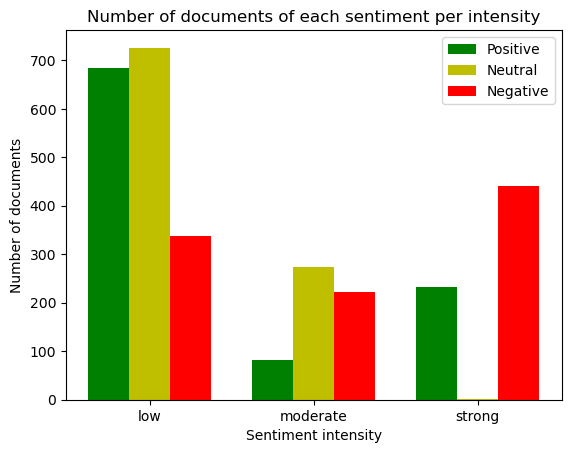

In [101]:
width = 0.25
fig = plt.plot(figsize = (10, 20))
nbr_pos_docs = nbr_sentiment_docs(res, 'positive')
bar1 = plt.bar(np.arange(3), nbr_pos_docs, width, color = 'g') 
  
nbr_neu_docs = nbr_sentiment_docs(res, 'neutral') 
bar2 = plt.bar(np.arange(3)+width, nbr_neu_docs, width, color='y') 
  
nbr_neg_docs = nbr_sentiment_docs(res, 'negative') 
bar3 = plt.bar(np.arange(3)+width*2, nbr_neg_docs, width, color = 'r') 
  
plt.xlabel("Sentiment intensity") 
plt.ylabel('Number of documents') 
plt.title("Number of documents of each sentiment per intensity") 
  
plt.xticks(np.arange(3)+width, ['low', 'moderate', 'strong']) 
plt.ylim = (0, 1000)
plt.legend( (bar1, bar2, bar3), ('Positive', 'Neutral', 'Negative') ) 
plt.show()